## Solar Panel Fault Identification 
### Task Model
Applied Machine Learning Project <br>

Solar Panel Fault Detection using CNN

**Task description and objectives**
- The aim of this project is to create a Machine Learning Model that accurately predicts and shows what type of defect a solar panel has, based on pictures of it.
- It will be a supervised learning model. 
- Supervised: Predict type or presence of defect (classification) based on sensor/thermal/image data.


In [6]:
# Libraries used throughout this script
import numpy as np
import matplotlib.pyplot as plt

# Libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.utils as vutils

### Dataset extraction

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/pythonafroz/solar-panel-images')
data_dir = './solar-panel-images/Faulty_solar_panel'

In [7]:
# Data transforms and splitting
img_size = 244
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # optional
])

# Full dataset with ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
print("Class labels:", class_names)

# Split into train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

torch.manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True
)

Class labels: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


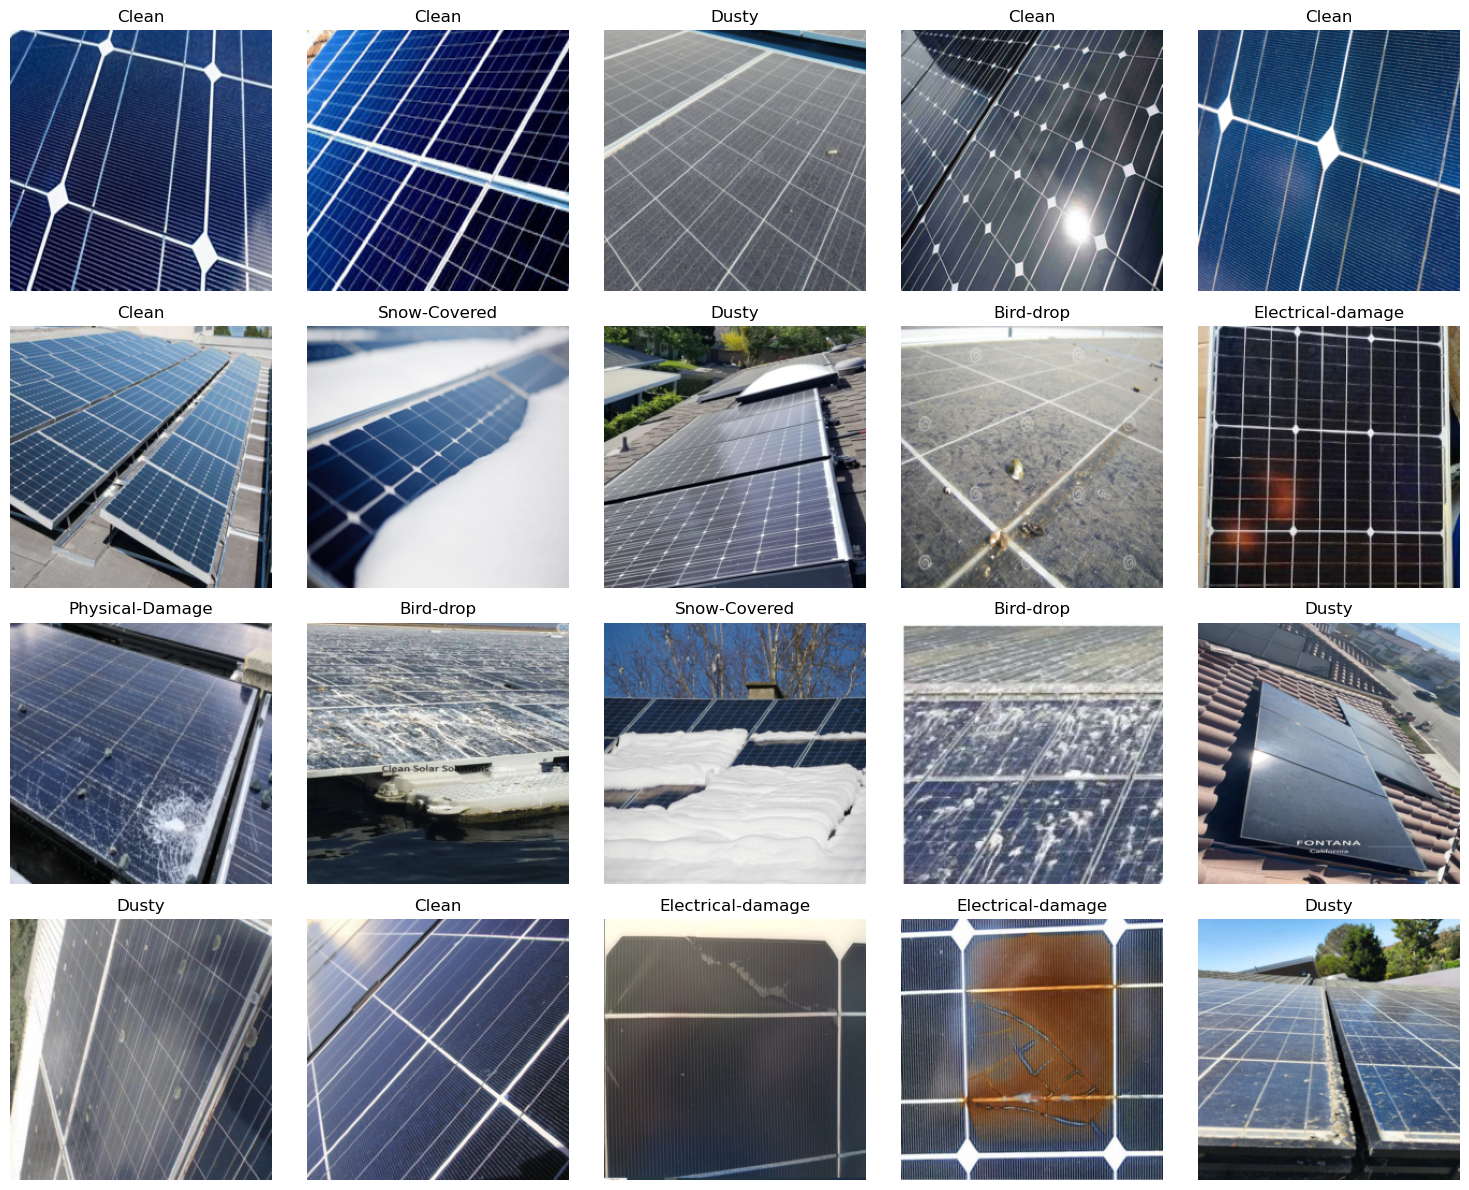

In [20]:
images, labels = next(iter(train_loader))
class_names = full_dataset.classes

plt.figure(figsize=(15, 12))
for i in range(20):  # Show 20 images
    ax = plt.subplot(4, 5, i + 1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

### CNN implementation

In [21]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.adaptpool = nn.AdaptiveAvgPool2d((5,5))  # ensure flatten size = 16*5*5
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(class_names))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.adaptpool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
# Initialize the network
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [23]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
# Check for proper GPU support
# Check CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [25]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"Loss: {running_loss / 50:.4f}")
            running_loss = 0.0

KeyboardInterrupt: 

In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# Show some predictions
images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,8))
grid = torchvision.utils.make_grid(images[:20], nrow=5)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.title([class_names[i] for i in preds[:20]])
plt.axis('off')
plt.show()
